# Load the function file and Inputs

## Function file 

In [5]:
%run -i XAI.py

In [6]:
def read_tabular_data(file_name, base_dir):
    df = os.path.join(base_dir, file_name)
    df_read = pd.read_csv(df, thousands=r',')
    return df_read


def data_reader_Comal(file_name, base_dir, skip_rows):
    df = os.path.join(base_dir, file_name)
    df_read = pd.read_csv(df, thousands=r',', skiprows=skip_rows)
    return df_read


## Path to save file

In [7]:
import os
save_Model = create_folder_to_save('/catboost_untuneddd')
#save_Model = make_path_to_save(Results,'Extra')
save_features = make_path_to_save(save_Model,'Features_importance')
saveRCP_45 = make_path_to_save(save_Model,'RCP45')
saveRCP_85 = make_path_to_save(save_Model,'RCP85')

In [8]:
#Importing the SA Intl climate data
base_dir = os.getcwd()+'/Input_Data'
filename = r"Daily Precipitation and Temperature - San Antonio TX Intl Airport from Sep 1 1946 to Nov 29 2020.csv"
df_hist_climate = read_tabular_data(filename, base_dir)

df_hist_climate.index = pd.DatetimeIndex(df_hist_climate['DATE'])

In [9]:

df_hist_climate_NOAA = pd.DataFrame()
df_hist_climate_NOAA['$T_{min}$ [$^oC$]'] = ((pd.to_numeric(df_hist_climate['DAILY MIN TEMP (DEG F)'], errors='coerce').values) - 32)*5/9
df_hist_climate_NOAA['$T_{max}$ [$^oC$]'] = ((pd.to_numeric(df_hist_climate['DAILY MAX TEMP (DEG F)'], errors='coerce').values) - 32)*5/9
df_hist_climate_NOAA['$P$ [mm]'] = (pd.to_numeric(df_hist_climate['DAILY PRECIPITATION (inches)'], errors='coerce').values)*25.4
df_hist_climate_NOAA.index = df_hist_climate.index
# df_hist_climate_NOAA
df_AI = pd.DataFrame()

df_AI['$T_{min}$ [$^oC$]'] = df_hist_climate_NOAA['$T_{min}$ [$^oC$]'].resample('W').mean()
df_AI['$T_{max}$ [$^oC$]'] = df_hist_climate_NOAA['$T_{max}$ [$^oC$]'].resample('W').mean()
df_AI['$P$ [mm]'] = df_hist_climate_NOAA['$P$ [mm]'].resample('W').sum()
df_AI.describe()

,$T_{min}$ [$^oC$],$T_{max}$ [$^oC$],$P$ [mm]
count,3875.000000,3875.000000,3875.000000
mean,14.749042,26.796088,14.946802
std,7.595685,7.133037,28.066030
min,-8.968254,1.111111,0.000000
25%,8.333333,21.349206,0.000000
50%,15.555556,27.539683,3.302000
75%,22.063492,32.857143,18.034000
max,26.428571,39.761905,383.794000


# Comal Springs

In [10]:
# -- Comal Springs Data 
skip_rows = 30
base_dir  = os.getcwd()+'/Input_Data'
filename  = r"Daily_SpringDischarge_Comal_Spring.csv"
#------
Comal_Spring_Flow_or = data_reader_Comal(filename, base_dir, skip_rows)
Comal_Spring_Flow_or  

Comal_Spring_Flow = []
Comal_Spring_Flow = Comal_Spring_Flow_or[['20d', '14n']].copy()
Comal_Spring_Flow = Comal_Spring_Flow.rename(columns = {'20d' : 'Date', '14n' : 'SF(cfs)'})

Comal_Spring_Flow['Date']  =  pd.to_datetime(Comal_Spring_Flow['Date'])
Comal_Spring_Flow['SF$[m^3/s]$'] = round(Comal_Spring_Flow['SF(cfs)'].astype(float)*0.028316847, 3)
Comal_Spring_Flow.drop(index=0,inplace=True)

Comal_Spring_Flow.index = pd.DatetimeIndex(Comal_Spring_Flow['Date'])
Comal_Spring_Flow.drop('Date',axis =1,inplace=True)

#Comal_Spring dataframe
Comal_Spring_Flow
#####
df_numeric_values_Cml = pd.to_numeric(Comal_Spring_Flow['SF$[m^3/s]$'], errors='coerce')

Comal_sf_data = df_numeric_values_Cml.to_frame()


#Data is Transformed to  Monthly mean from daily data and truncated 
SF_Data = Comal_sf_data.resample('W').mean()
SF_Data


#df_AI = (df_AI[(df_AI.index >= '1956-05-27') & (df_AI.index <= '2020-06-07')])
#df_AI

df_AI['SF$[m^3/s]$'] = (SF_Data[(SF_Data.index >= '1946-09-01')& (SF_Data.index <= '2020-11-29')])

df_AI = df_AI[(df_AI.index >= '1960-09-01')]
df_AI.describe()


,$T_{min}$ [$^oC$],$T_{max}$ [$^oC$],$P$ [mm],SF$[m^3/s]$
count,3144.000000,3144.000000,3144.000000,3144.000000
mean,14.817087,26.793792,15.454413,8.277359
std,7.629288,7.103033,28.606174,2.412999
min,-6.666667,1.111111,0.000000,0.750000
25%,8.333333,21.507937,0.000000,6.642143
50%,15.674603,27.539683,3.556000,8.493071
75%,22.142857,32.777778,19.050000,10.032321
max,26.428571,39.761905,383.794000,14.401000


In [11]:
# Pumping patterns is hypothesized to be associated with the month
df_AI['Month'] = df_AI.index.month 

# reate lag
df_AI['$T_{max}^{lag1}$ [$^oC$]'] = df_AI['$T_{max}$ [$^oC$]'].shift(1)
df_AI['$T_{max}^{lag2}$ [$^oC$]'] = df_AI['$T_{max}$ [$^oC$]'].shift(2)

df_AI['$T_{min}^{lag1}$ [$^oC$]'] = df_AI['$T_{min}$ [$^oC$]'].shift(1)
df_AI['$T_{min}^{lag2}$ [$^oC$]'] = df_AI['$T_{min}$ [$^oC$]'].shift(2)

df_AI['$P^{lag1}$ [mm]'] = df_AI['$P$ [mm]'].shift(1)
df_AI['$P^{lag2}$ [mm]'] = df_AI['$P$ [mm]'].shift(2)

df_AI['SF$^{lag1} [m^3/s]$'] = df_AI['SF$[m^3/s]$'].shift(1)
df_AI['SF$^{lag2} [m^3/s]$'] = df_AI['SF$[m^3/s]$'].shift(2)

df_AI.dropna(inplace=True)


# Train and Test the model

In [12]:

Features = ['Month','$T_{min}$ [$^oC$]','$T_{max}$ [$^oC$]','$P$ [mm]',
            '$P^{lag1}$ [mm]','$P^{lag2}$ [mm]',
            'SF$^{lag1} [m^3/s]$','SF$^{lag2} [m^3/s]$']

#SpringFlow for Comal = Target
Target = ['SF$[m^3/s]$']




df_AI_Train = df_AI[:'2008-12-31']
df_AI_Test = df_AI['2009-01-01':]

#Create Independent and dependent variable for machine learning
X = df_AI[Features].to_numpy()
Y = df_AI[Target].to_numpy()

In [13]:
train_X = df_AI_Train[Features].to_numpy()
train_y = df_AI_Train[Target].to_numpy()
test_X = df_AI_Test[Features].iloc[0].to_numpy().reshape(1, -1)



Learning rate set to 0.047381
0:	learn: 2.2995672	total: 2.1ms	remaining: 2.1s
1:	learn: 2.2088493	total: 3.53ms	remaining: 1.76s
2:	learn: 2.1176103	total: 4.91ms	remaining: 1.63s
3:	learn: 2.0355900	total: 6.2ms	remaining: 1.54s
4:	learn: 1.9542403	total: 7.29ms	remaining: 1.45s
5:	learn: 1.8742977	total: 8.26ms	remaining: 1.37s
6:	learn: 1.7963019	total: 9.22ms	remaining: 1.31s
7:	learn: 1.7266700	total: 10.3ms	remaining: 1.27s
8:	learn: 1.6563699	total: 11.2ms	remaining: 1.24s
9:	learn: 1.5878998	total: 12.2ms	remaining: 1.2s
10:	learn: 1.5244606	total: 13.3ms	remaining: 1.2s
11:	learn: 1.4634302	total: 14.3ms	remaining: 1.18s
12:	learn: 1.4050990	total: 15.2ms	remaining: 1.15s
13:	learn: 1.3523692	total: 16.1ms	remaining: 1.13s
14:	learn: 1.2981824	total: 17.2ms	remaining: 1.13s
15:	learn: 1.2481475	total: 18.1ms	remaining: 1.11s
16:	learn: 1.1987057	total: 19ms	remaining: 1.1s
17:	learn: 1.1530784	total: 19.9ms	remaining: 1.09s
18:	learn: 1.1123786	total: 20.7ms	remaining: 1.07s


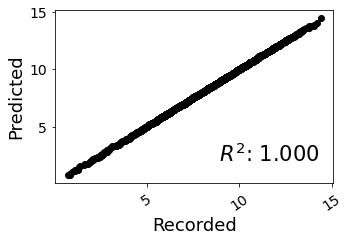

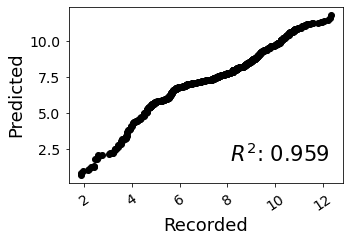

In [35]:
#Model = ExtraTreesRegressor(max_depth = 30, n_estimators=477)
import catboost as cb

Model = cb.CatBoostRegressor()
Model.fit(train_X, train_y.ravel())
print_results(Model,train_X,train_y,save_Model)

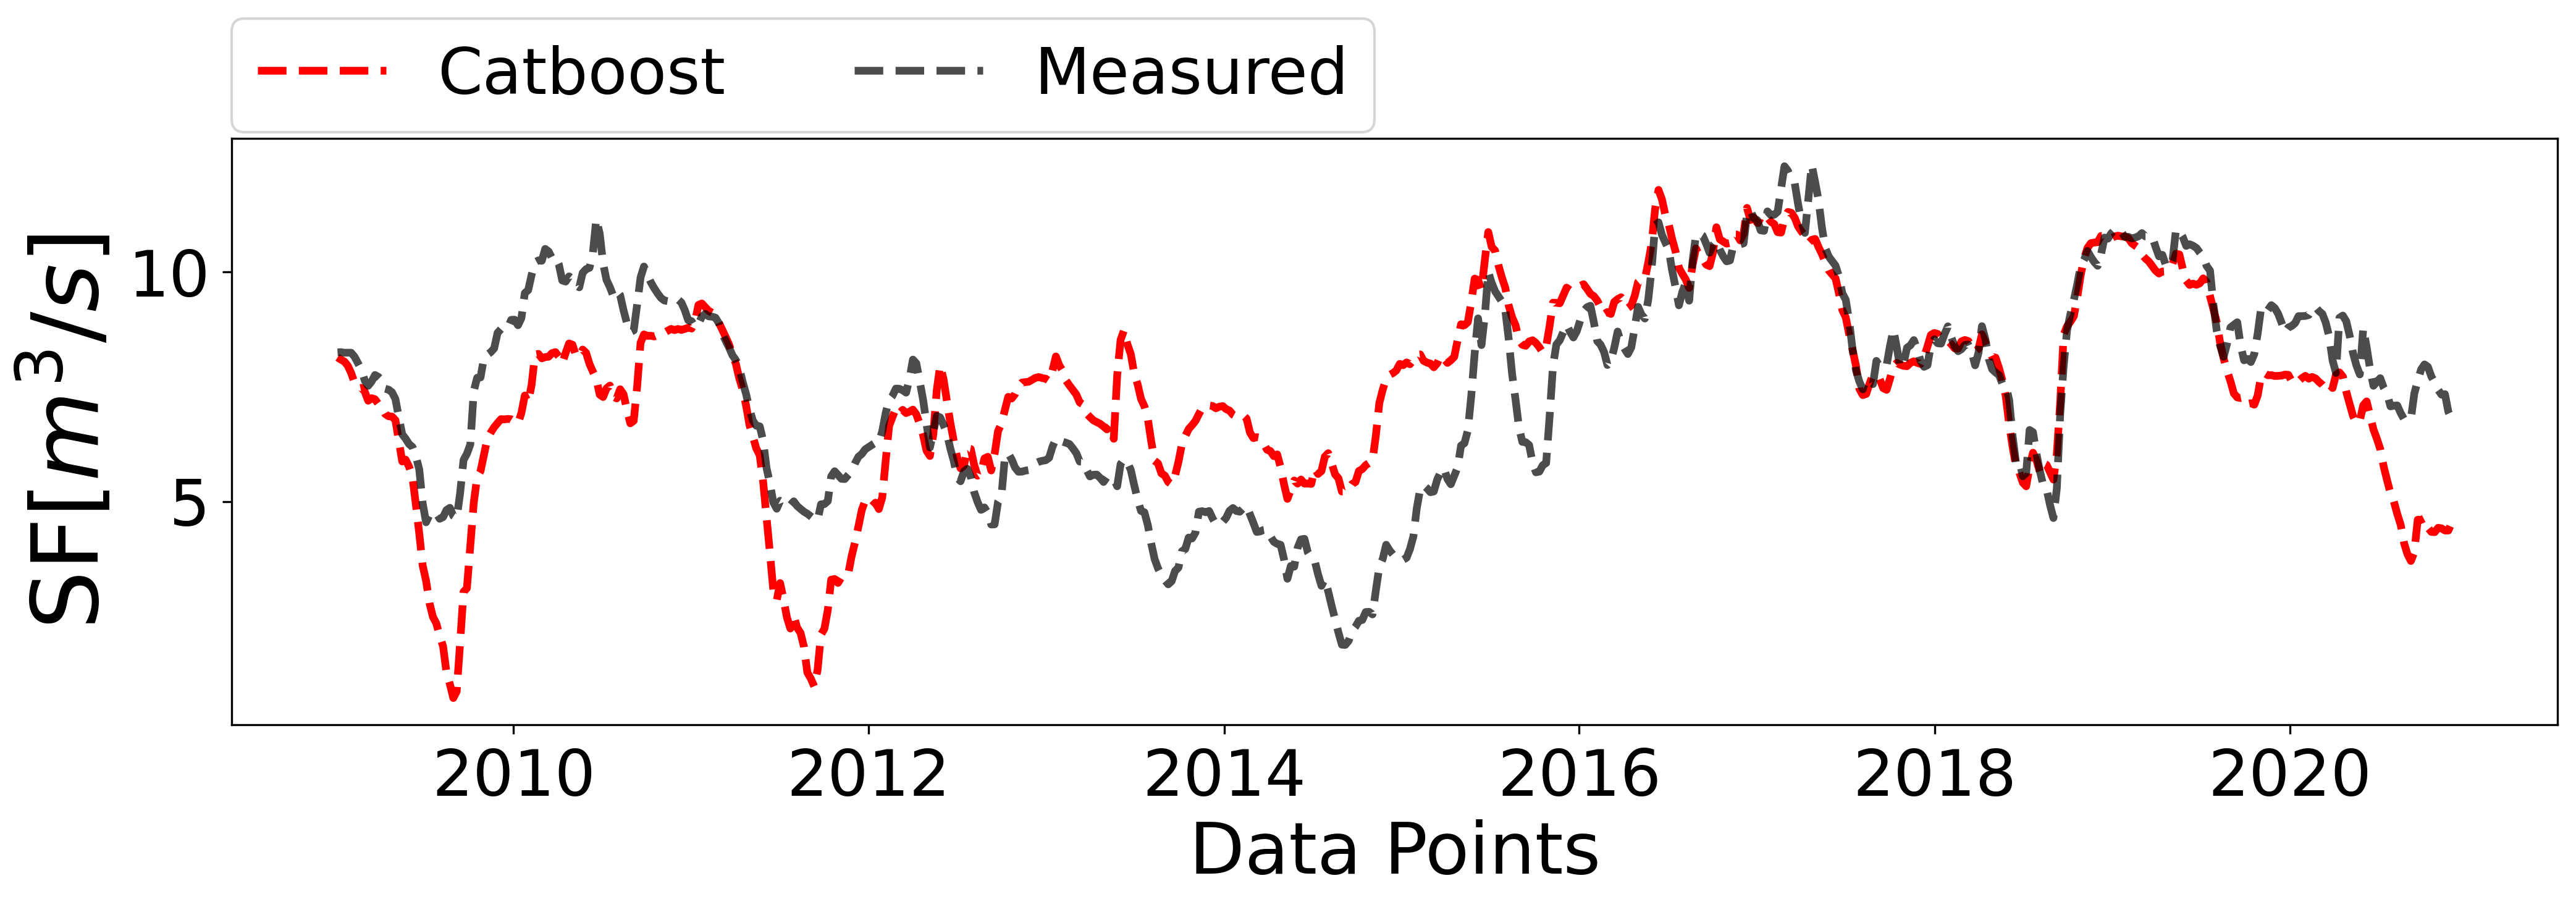

In [36]:
plot_test(df_AI_Test, save_Model, "Catboost")

# Shapley analysis

In [37]:
import numpy as np
import pandas as pd
import xgboost as xgb
import datatable as dt # data table factory
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import explainerdashboard as expdb
from explainerdashboard import RegressionExplainer, ExplainerDashboard
from explainerdashboard import InlineExplainer
from explainerdashboard.custom import (ImportancesComposite,
                                       IndividualPredictionsComposite,
                                       WhatIfComposite,
                                       ShapDependenceComposite,
                                       ShapInteractionsComposite,
                                       DecisionTreesComposite)

In [38]:
from explainerdashboard import RegressionExplainer, ExplainerDashboard

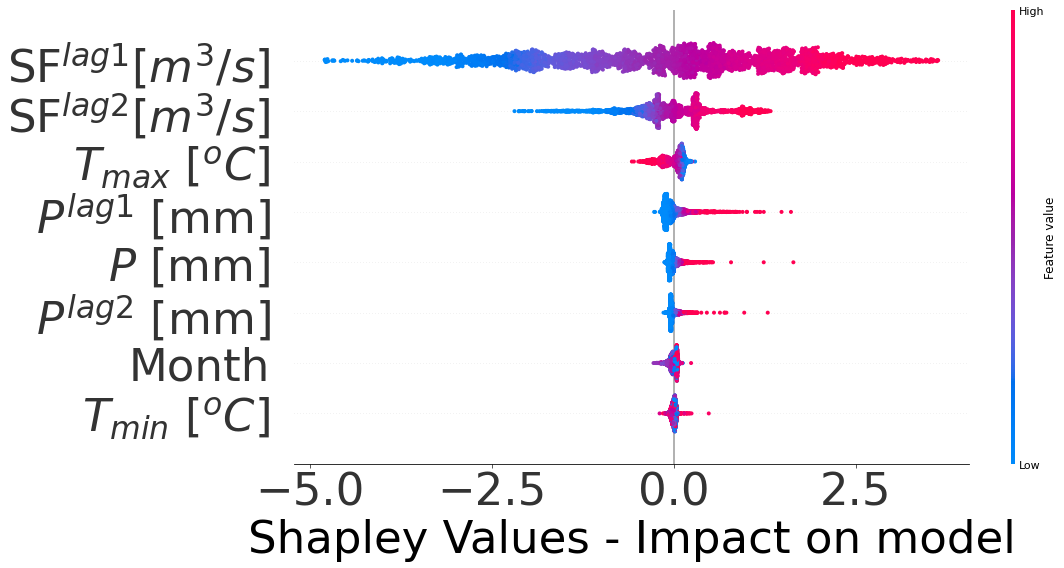

In [39]:
explainer = shap.TreeExplainer(Model)
shap_values = explainer.shap_values(df_AI[Features].to_numpy())

shap.summary_plot(shap_values, df_AI[Features].to_numpy(), Features, plot_size=(16,8), show=False)
plt.xlabel('Shapley Values - Impact on model', fontsize=45)
plt.tick_params(labelsize=45)
plt.tight_layout(pad=1.08)
plt.savefig(save_features +str('/Feature Importance - SF -_XGBoost.pdf'), format='jpeg', dpi=300, bbox_inches ='tight')

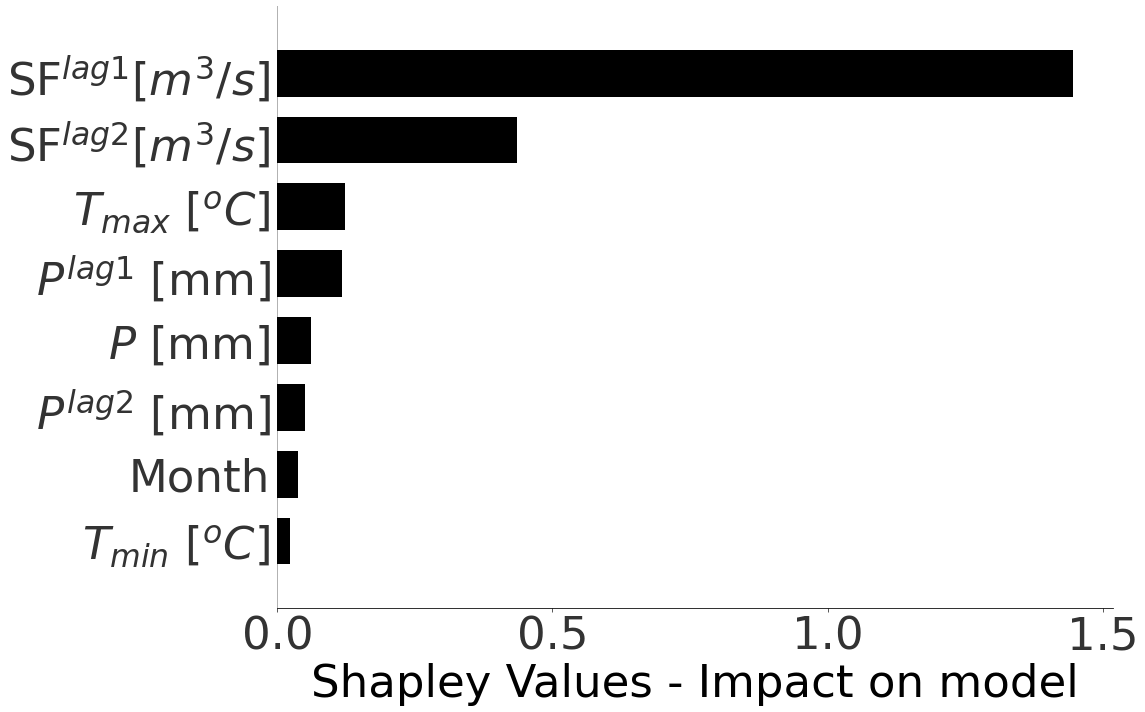

In [40]:

explainer = shap.TreeExplainer(Model)
shap_values = explainer.shap_values(df_AI[Features].to_numpy())

shap.summary_plot(shap_values, df_AI[Features].to_numpy(), Features, plot_size=(16,10), show=False, 
                  plot_type = "bar", color = "black")
plt.xlabel('Shapley Values - Impact on model', fontsize=45)
plt.tick_params(labelsize=45)
plt.tight_layout(pad=1.08)
plt.savefig(save_features + str('/Feature Importances - SF_- Hist.jpg'), format='jpeg', dpi=300, bbox_inches ='tight')


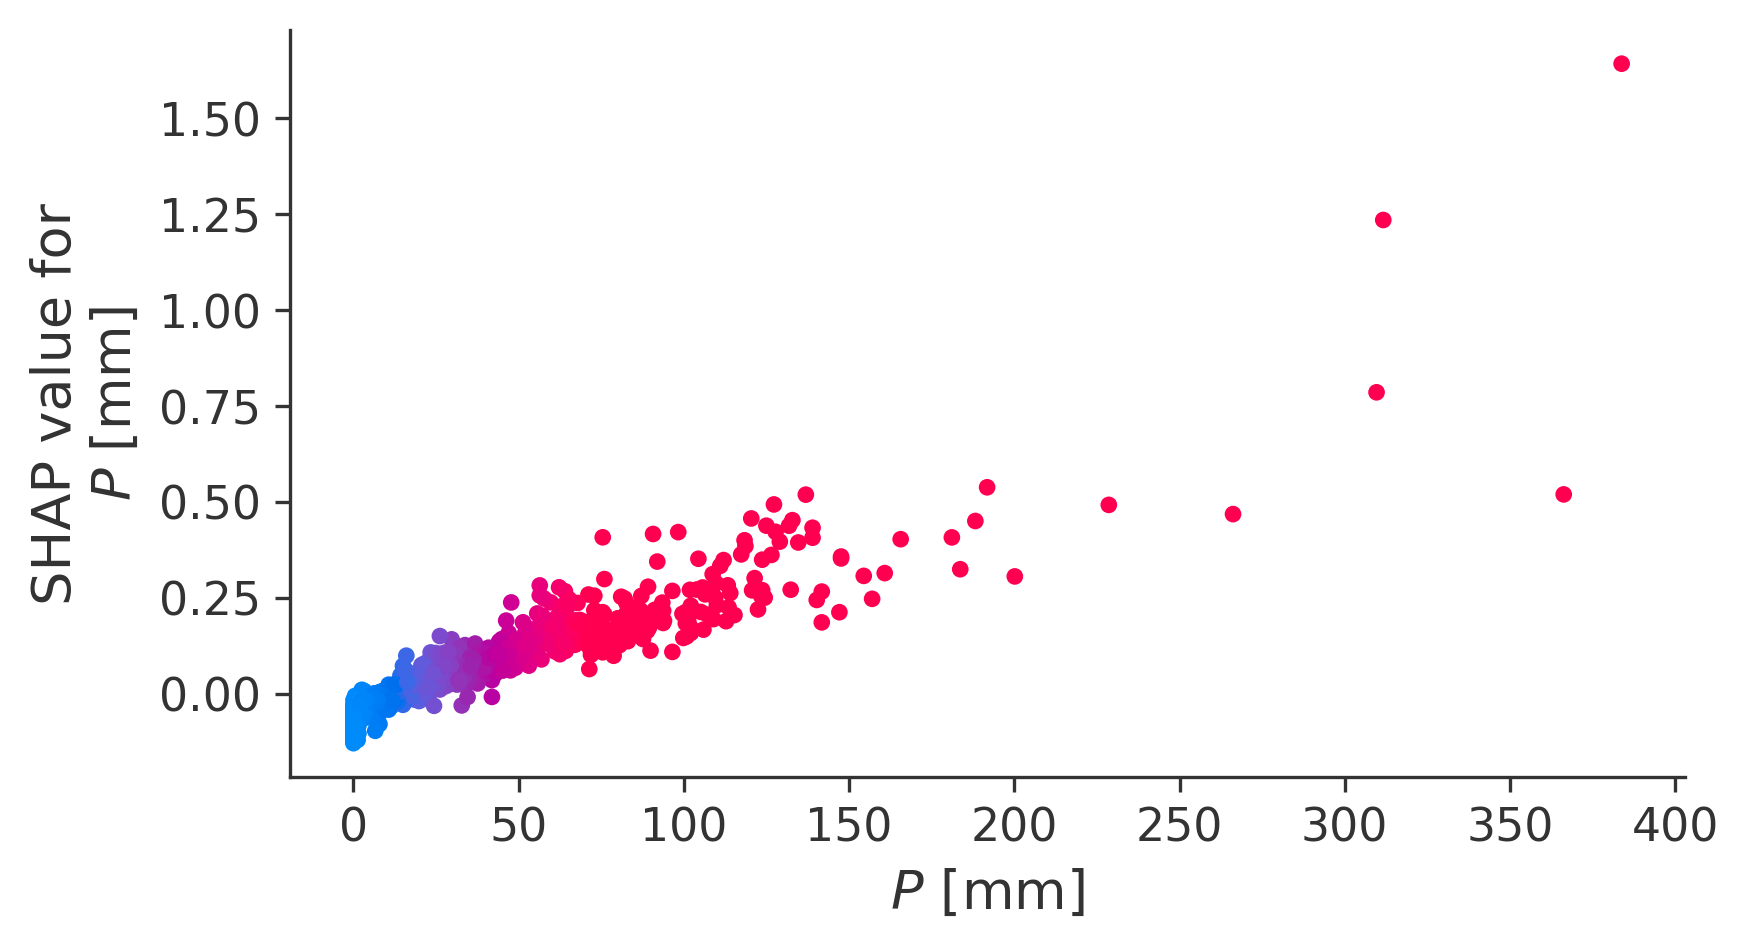

In [41]:
fig = plt.figure(figsize=(6,3.3),dpi=300)
ax1 = fig.add_subplot(1,1,1)

   
shap.dependence_plot('$P$ [mm]',shap_values, df_AI[Features].to_numpy(),Features, ax=ax1, show=False,
                     interaction_index='$P$ [mm]')
plt.savefig(save_features +str('/Pr -.jpg'), format='jpeg', dpi=300, bbox_inches ='tight')


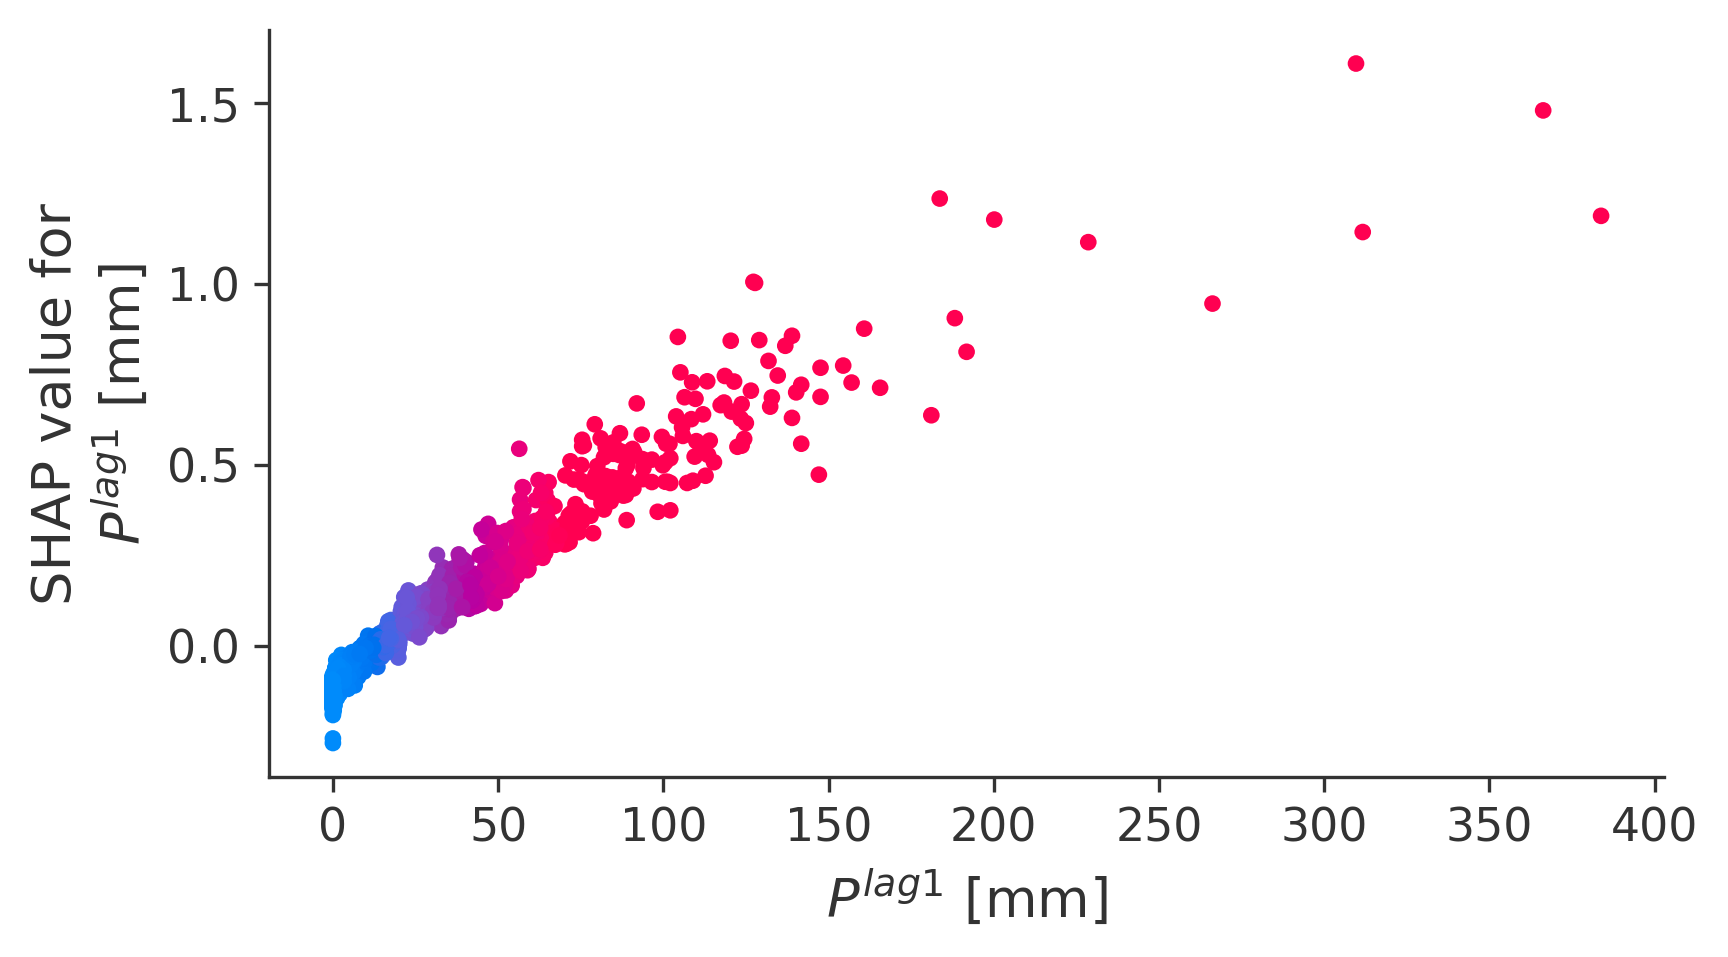

In [42]:
fig = plt.figure(figsize=(6,3.3),dpi=300)
ax1 = fig.add_subplot(1,1,1)

   
shap.dependence_plot( '$P^{lag1}$ [mm]',shap_values, df_AI[Features].to_numpy(),Features, ax=ax1, show=False,
                     interaction_index= '$P^{lag1}$ [mm]')
plt.savefig(save_features +str('/Prlag1 -.jpg'), format='jpeg', dpi=300, bbox_inches ='tight')


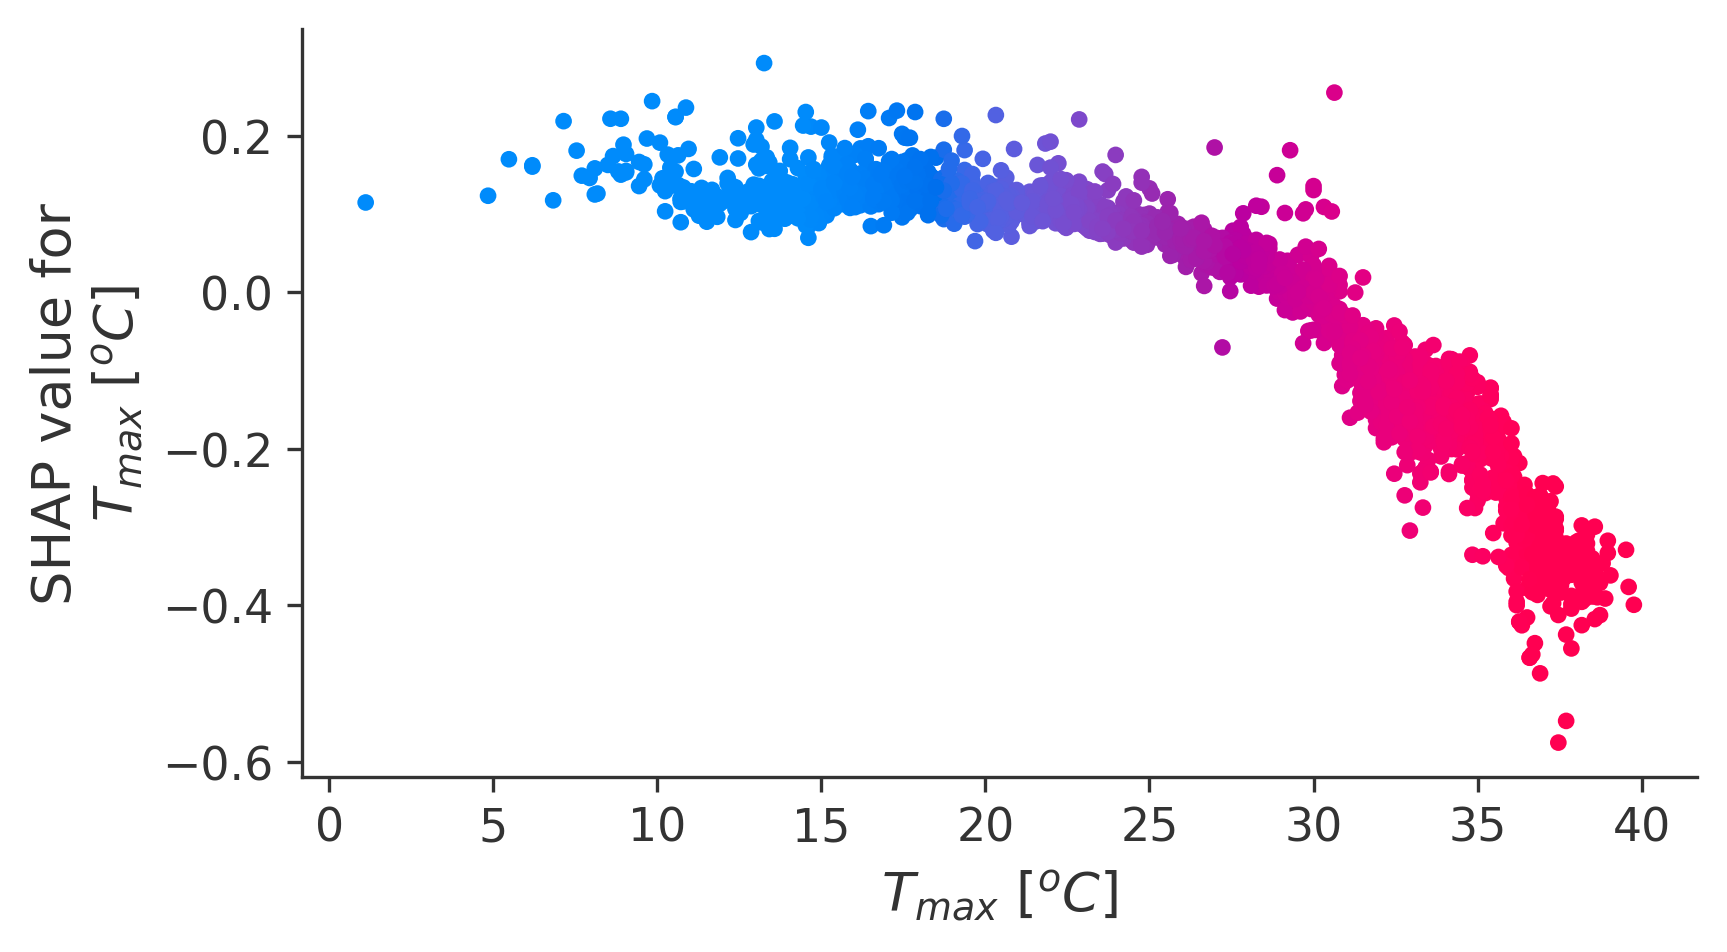

In [43]:

fig = plt.figure(figsize=(6,3.3),dpi=300)
ax1 = fig.add_subplot(1,1,1)

   
shap.dependence_plot('$T_{max}$ [$^oC$]', shap_values, df_AI[Features].to_numpy(),Features, ax=ax1, show=False,
                     interaction_index='$T_{max}$ [$^oC$]')
plt.savefig(save_features +str('/Tmax - Hist.jpg'), format='jpeg', dpi=300, bbox_inches ='tight')


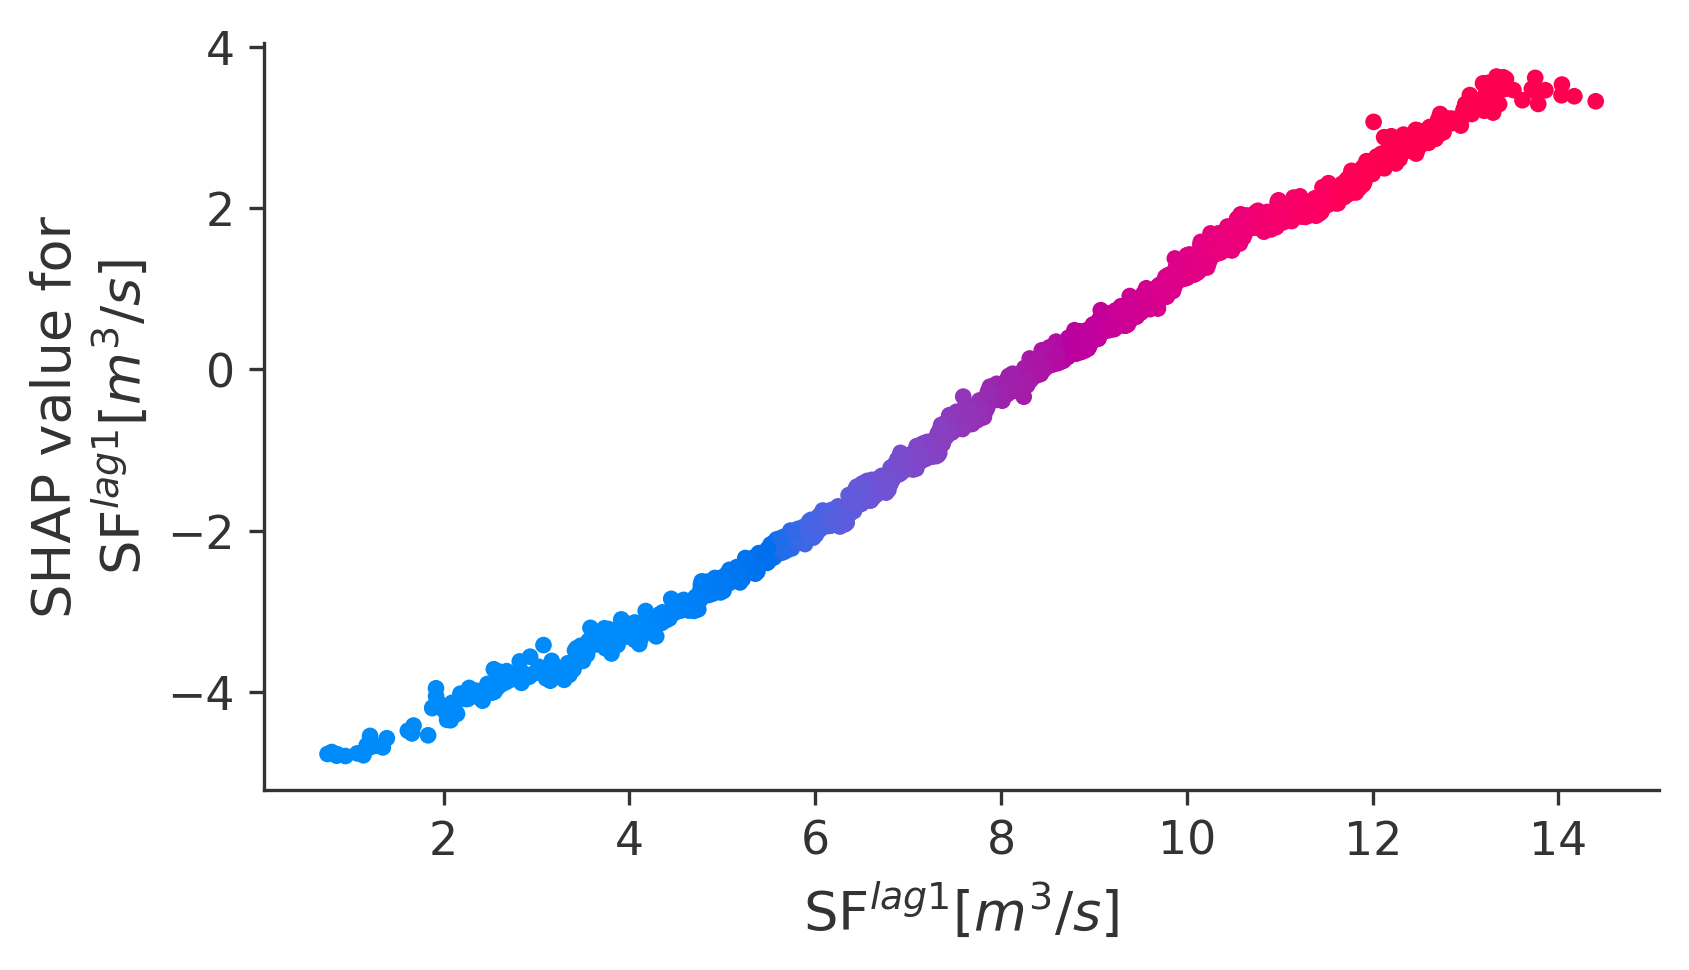

In [44]:

fig = plt.figure(figsize=(6,3.3),dpi=300)
ax1 = fig.add_subplot(1,1,1)

   
shap.dependence_plot('SF$^{lag1} [m^3/s]$',shap_values, df_AI[Features].to_numpy(),Features, ax=ax1, show=False,
                     interaction_index='SF$^{lag1} [m^3/s]$')
plt.savefig(save_features+str('/SF_Lag1 Hist.jpg'), format='jpeg', dpi=300, bbox_inches ='tight')




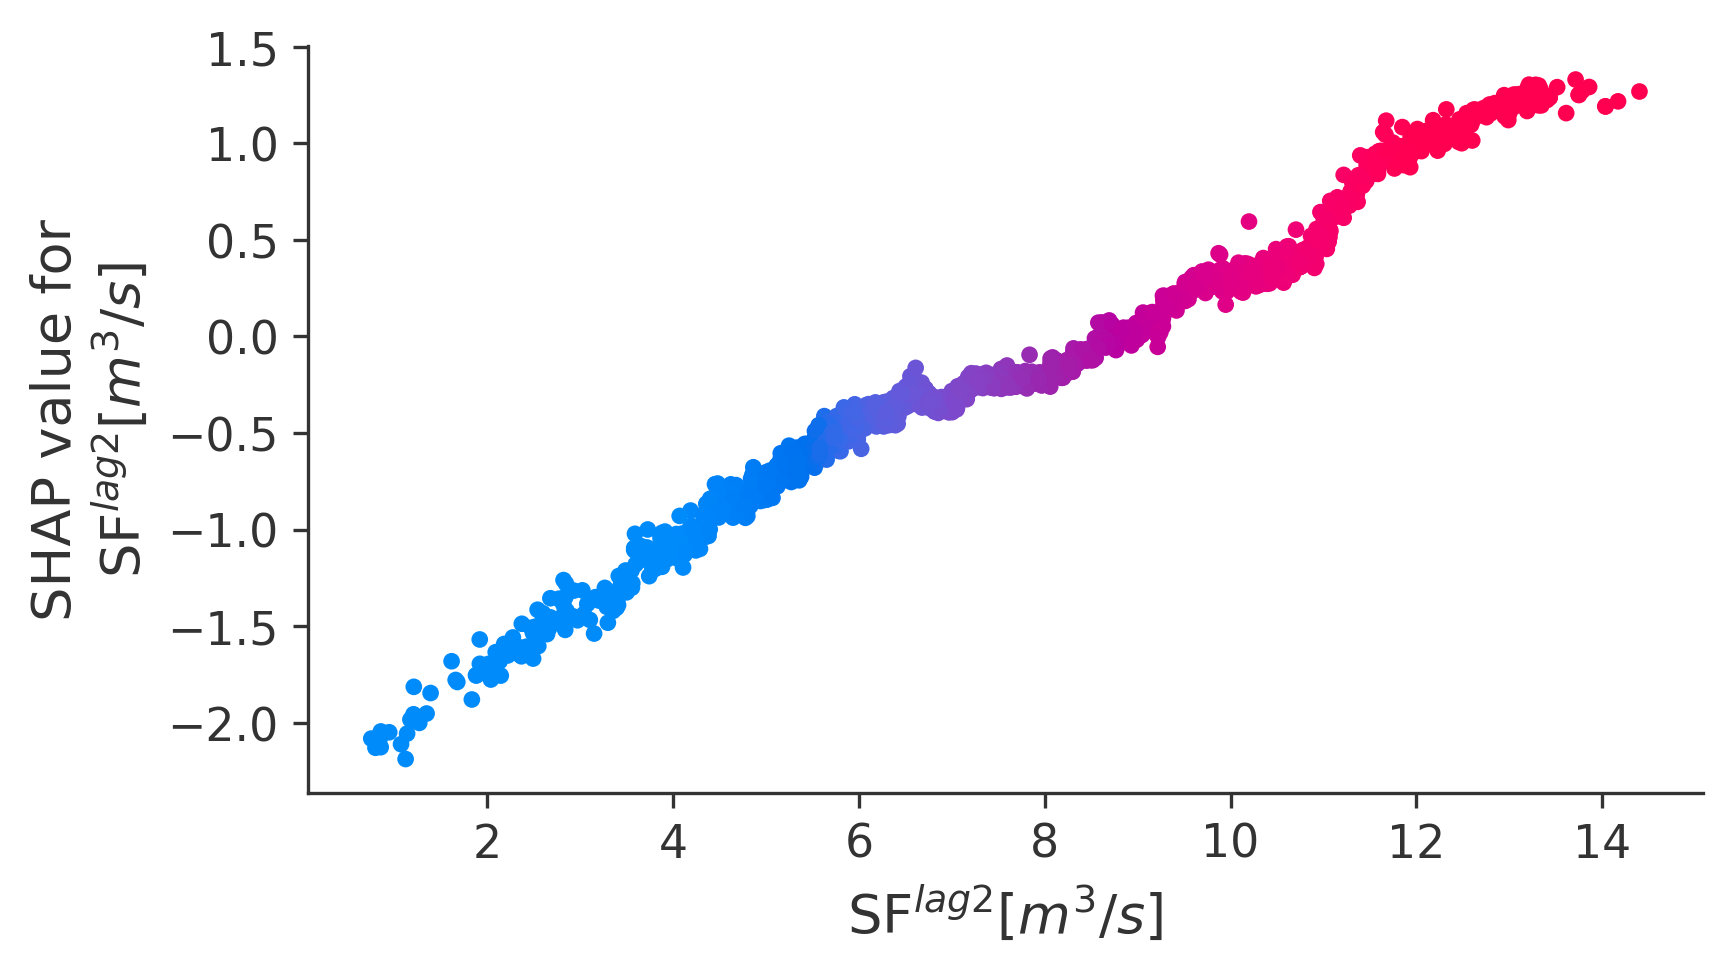

In [45]:
fig = plt.figure(figsize=(6,3.3),dpi=300)
ax1 = fig.add_subplot(1,1,1)

   
shap.dependence_plot('SF$^{lag2} [m^3/s]$',shap_values, df_AI[Features].to_numpy(),Features, ax=ax1, show=False,
                     interaction_index='SF$^{lag2} [m^3/s]$')
plt.savefig(save_features +str('/SF_Lag2 Hist.jpg'), format='jpeg', dpi=300, bbox_inches ='tight')


In [46]:
df_AI.to_excel(save_Model +'/df_AI.xlsx')

In [50]:
def read_data(file_name, base_dir, num_skip_rows):
    df = os.path.join(base_dir, file_name)
    df_read = pd.read_csv(df, thousands=r',', low_memory=False, skiprows = num_skip_rows)
    return df_read


def MACA_data(base_dir, file_name):
    data_M_Hist = []
    data_M_Hist = read_data(file_name, base_dir, num_skip_rows)

    data_M_Hist.rename(columns={data_M_Hist.columns[0]: 'Date',     data_M_Hist.columns[1]: 'Tmin[K]',
                                data_M_Hist.columns[2]: 'Tmax[K]', data_M_Hist.columns[3]: 'Precip[mm]'},
                       inplace=True)

    data_M_Hist['Tmin[C]'] = (data_M_Hist['Tmin[K]'] - 273.15).astype(float)
    data_M_Hist['Tmax[C]'] = (data_M_Hist['Tmax[K]'] - 273.15).astype(float)

    data_M_Hist['Tmin[C]'].interpolate(
        method='linear', limit_direction='both', inplace=True)
    data_M_Hist['Tmax[C]'].interpolate(
        method='linear', limit_direction='both', inplace=True)
    data_M_Hist['Precip[mm]'].interpolate(
        method='linear', limit_direction='both', inplace=True)
    return data_M_Hist


num_skip_rows = 12
#-------------------------
# RCP 4.5 - M1-Tmax; M5-Precip; M16-Tmin
#-------------------------
base_dir = os.getcwd()+"/Downscaled_MACA_Climate_Data/M16_MIROC5_Japan"
file_name = r"RCP_4_5/data.csv"
temp = MACA_data(base_dir, file_name)

df_MACA_RCP45 = pd.DataFrame()
df_MACA_RCP45[['Date', '$T_{max}$ [$^oC$]']] = temp[['Date', 'Tmax[C]']]
df_MACA_RCP45.index = pd.DatetimeIndex(df_MACA_RCP45['Date'])
df_MACA_RCP45.drop(['Date'], axis=1, inplace=True)


base_dir = os.getcwd()+"/Downscaled_MACA_Climate_Data/M5_CCSM4_USA"
file_name = r"RCP_4_5/data.csv"
temp = MACA_data(base_dir, file_name)
df_MACA_RCP45['$P$ [mm]'] = temp['Precip[mm]'].values


base_dir = os.getcwd()+"/Downscaled_MACA_Climate_Data/M20_NorESM1_M_Norway"
file_name = r"RCP_4_5/data.csv"
temp = MACA_data(base_dir, file_name)
df_MACA_RCP45['$T_{min}$ [$^oC$]'] = temp['Tmin[C]'].values


df_RCP45_MACA = pd.DataFrame()
df_RCP45_MACA['$T_{min}$ [$^oC$]'] = df_MACA_RCP45['$T_{min}$ [$^oC$]'].resample(
    'W').mean().values

df_RCP45_MACA['$T_{max}$ [$^oC$]'] = df_MACA_RCP45['$T_{max}$ [$^oC$]'].resample(
    'W').mean().values
df_RCP45_MACA['$P$ [mm]'] = df_MACA_RCP45['$P$ [mm]'].resample(
    'W').sum().values
df_RCP45_MACA.describe()

,$T_{min}$ [$^oC$],$T_{max}$ [$^oC$],$P$ [mm]
count,4906.000000,4906.000000,4906.000000
mean,16.267201,29.449579,15.909449
std,7.614883,7.466808,30.876179
min,-6.800552,2.217379,0.000000
25%,9.809292,23.725248,0.487135
50%,17.204996,30.375417,4.444767
75%,23.368207,35.634299,18.378493
max,30.541171,47.351195,553.350795


In [ ]:
%run -i XAI.py

In [ ]:
df_MACA_RCP45[(df_MACA_RCP45.index >'2020-11-29')]

,$T_{max}$ [$^oC$],$P$ [mm],$T_{min}$ [$^oC$]
Date,,,
2020-11-30,20.552911,0.000000,13.364008
2020-12-01,20.439874,0.000000,16.024225
2020-12-02,19.980341,0.000000,15.750391
2020-12-03,17.368921,0.000000,13.016962
2020-12-04,16.588800,0.000000,15.037042
...,...,...,...
2099-12-27,10.701624,0.000000,5.952844
2099-12-28,13.796136,0.000000,7.999536
2099-12-29,15.749323,0.000000,8.164880


############ Model Validation set Accuracy RCP 4.5###########
MAE: 0.652 m/s^3
NSE: 0.885
RMS: 0.782 m/s^3
R-squared: 0.885
########################################
 
########################################
 


,Month,$T_{min}$ [$^oC$],$T_{max}$ [$^oC$],$P$ [mm],SF$[m^3/s]$
count,4748.000000,4748.000000,4748.000000,4748.000000,4748.000000
mean,6.521904,16.307442,29.513812,15.915394,5.553361
std,3.448643,7.620982,7.471514,31.057825,2.160556
min,1.000000,-6.800552,2.217379,0.000000,1.535137
25%,4.000000,9.844935,23.770950,0.485398,4.133644
50%,7.000000,17.239967,30.485734,4.426141,5.470920
75%,10.000000,23.431822,35.682369,18.300679,6.752067
max,12.000000,30.541171,47.351195,553.350795,11.696263


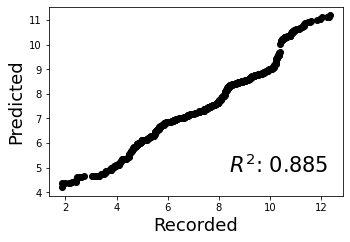

In [ ]:
######## RCP(rcp_dataframe,df_AI, model, scenerio, save_to)
Approved_date = '2020-11-30'
df_future_45= RCP(df_RCP45_MACA,df_AI,Model, 4.5, saveRCP_45)
df_future_45.to_excel(saveRCP_45+str('/df_future_RCP45.xlsx'))
df_future_45.describe()

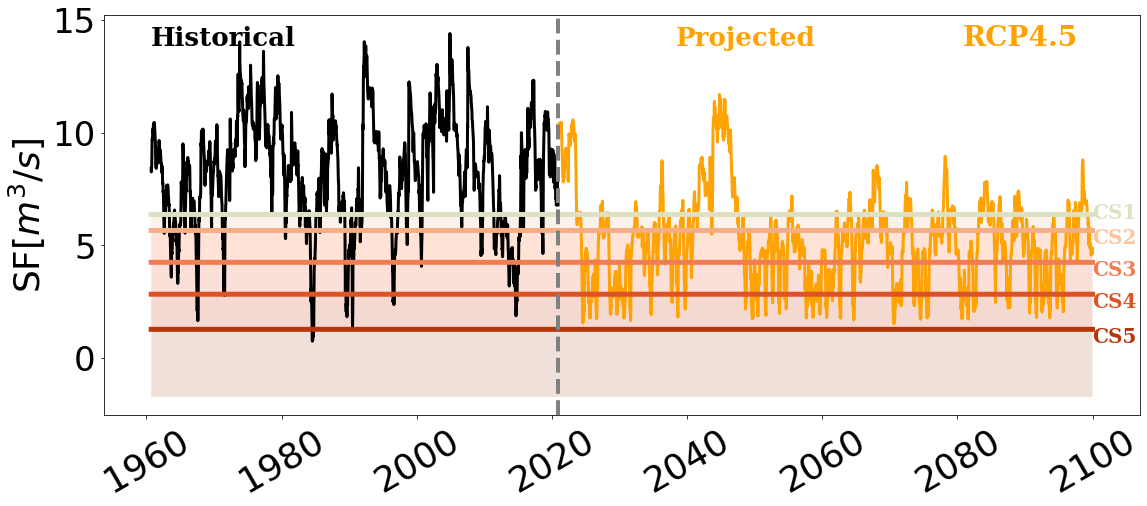

In [ ]:
plot_projections(df_future_45,df_AI,4.5,saveRCP_45)

## RCP 8.5

In [ ]:
#-------------------------
# RCP 8.5 - M1-Tmax; M5-Precip; M16-Tmin
#-------------------------
base_dir  = r"/Input_Data/Downscaled_MACA_Climate_Data/M16_MIROC5_Japan"
file_name = r"RCP_8_5/data.csv"
temp = MACA_data(base_dir, file_name)

df_MACA_RCP85 = pd.DataFrame()
df_MACA_RCP85[['Date','$T_{max}$ [$^oC$]']] = temp[['Date','Tmax[C]']]
df_MACA_RCP85.index = pd.DatetimeIndex(df_MACA_RCP85['Date'])
df_MACA_RCP85.drop(['Date'],axis=1,inplace=True)


base_dir  = r"/Input_Data/Downscaled_MACA_Climate_Data/M5_CCSM4_USA"
file_name = r"RCP_8_5/data.csv"
temp = MACA_data(base_dir, file_name)
df_MACA_RCP85['$P$ [mm]'] = temp['Precip[mm]'].values


base_dir  = r"/Input_Data/Downscaled_MACA_Climate_Data/M20_NorESM1_M_Norway"
file_name = r"RCP_8_5/data.csv"
temp = MACA_data(base_dir, file_name)
df_MACA_RCP85['$T_{min}$ [$^oC$]'] = temp['Tmin[C]'].values


df_RCP85_MACA = pd.DataFrame()
df_RCP85_MACA['$T_{min}$ [$^oC$]'] = df_MACA_RCP85['$T_{min}$ [$^oC$]'].resample('W').mean()
df_RCP85_MACA['$T_{max}$ [$^oC$]'] = df_MACA_RCP85['$T_{max}$ [$^oC$]'].resample('W').mean().values
df_RCP85_MACA['$P$ [mm]'] = df_MACA_RCP85['$P$ [mm]'].resample('W').sum().values
df_RCP85_MACA.describe()

,$T_{min}$ [$^oC$],$T_{max}$ [$^oC$],$P$ [mm]
count,4906.000000,4906.000000,4906.000000
mean,17.351381,30.211837,15.564499
std,7.483686,7.608645,29.840794
min,-6.817651,6.143688,0.000000
25%,11.219275,24.362871,0.440705
50%,18.236111,31.085125,4.214950
75%,24.107307,36.424864,17.515275
max,32.665800,47.101548,339.089812


############ Model Validation set Accuracy RCP 8.5###########
MAE: 0.938 m/s^3
NSE: 0.791
RMS: 1.056 m/s^3
R-squared: 0.791
########################################
 
########################################
 


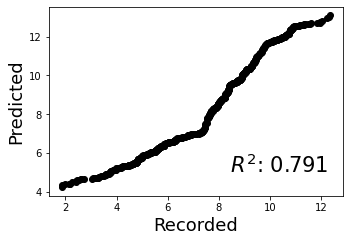

In [ ]:
Approved_date = '2020-11-30'
df_future_85= RCP(df_RCP85_MACA,df_AI,Model,8.5,saveRCP_85)
df_future_85.describe()

df_future_85.to_excel(saveRCP_85+str('/df_future_RCP85.xlsx'))

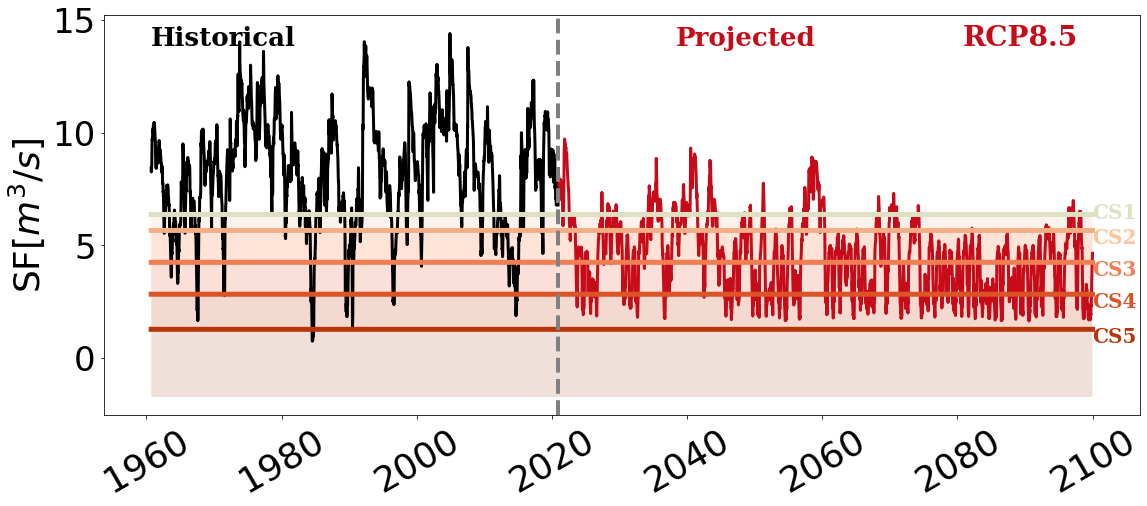

In [ ]:
plot_projections(df_future_85,df_AI,8.5,saveRCP_85)

# Terraclimate 

In [ ]:
df_AI2 = pd.DataFrame()

df_AI2['$T_{min}$ [$^oC$]'] = df_hist_climate_NOAA['$T_{min}$ [$^oC$]'].resample('M').mean()
df_AI2['$T_{max}$ [$^oC$]'] = df_hist_climate_NOAA['$T_{max}$ [$^oC$]'].resample('M').mean()
df_AI2['$P$ [mm]'] = df_hist_climate_NOAA['$P$ [mm]'].resample('M').sum()

df_AI2 = (df_AI2[(df_AI2.index>='1960-09-01')&(df_AI2.index <= '2019-12-31')])
df_AI2

df_AI2.describe()

,$T_{min}$ [$^oC$],$T_{max}$ [$^oC$],$P$ [mm]
count,712.000000,712.000000,712.000000
mean,14.746564,26.721704,67.532250
std,7.170900,6.664130,68.030336
min,-0.250896,11.326165,0.000000
25%,8.232527,20.873656,18.478500
50%,15.175926,27.546296,48.768000
75%,21.833333,32.652778,90.805000
max,25.806452,38.620072,458.978000


In [ ]:
# TerraClimate Data at Cibolo
base_dir = r"/Input_Data/TerraClimate_Data"
###################################################################################################
filename = r"ETa_CibolaNC_TerraClimate.csv"
df_ETa = read_tabular_data(filename, base_dir)
df_ETa = df_ETa.rename(columns = \
                       {'(mm) Actual ET (TerraClimate) at -98.7092E,29.7839N, 1958-01-01 to 2019-12-31' : \
                        '$ET$ [mm]'})

df_ETa.index = pd.DatetimeIndex(df_ETa['DateTime'])
df_ETa.drop('DateTime',axis=1,inplace=True)

###################################################################################################

###################################################################################################
filename = r"Sm_CibolaNC_TerraClimate.csv"
df_Sm = read_tabular_data(filename, base_dir)
df_Sm = df_Sm.rename(columns = \
                       {'(mm) Soil Moisture (TerraClimate) at -98.7092E,29.7839N, 1958-01-01 to 2019-12-31' : \
                        'SM [mm]'})


df_Sm.index = pd.DatetimeIndex(df_Sm['DateTime'])
df_Sm.drop('DateTime',axis=1,inplace=True)
###################################################################################################



# df_CibolaNC = pd.concat([df_Rd,df_Ta,df_Pr,df_u2,df_ETo,df_ETa,df_Sm,df_Rw],axis=1)
df_Terraclimate = pd.concat([df_ETa,df_Sm],axis=1)
df_Terraclimate.interpolate(method = 'linear', limit_direction = 'both', inplace =True)


In [ ]:
#df_AI2['$R_w$ [mm]'] = df_AI22['$R_w$ [mm]'].to_numpy()


df_Terraclimate = df_Terraclimate[(df_Terraclimate.index >= "1960-09") &( df_Terraclimate.index <= '2019-12-31')]

df_Terraclimate

,$ET$ [mm],SM [mm]
DateTime,,
1960-09-01,23.7,22.8
1960-10-01,115.5,119.4
1960-11-01,54.6,102.6
1960-12-01,63.4,135.8
1961-01-01,41.4,118.5
...,...,...
2019-08-01,32.8,37.9
2019-09-01,34.8,32.3
2019-10-01,110.4,30.8


In [ ]:


#Data is Transformed to  Monthly mean from daily data and truncated 
SF_Data = Comal_sf_data.resample('M').mean()
SF_Data

df_AI2['SF$[m^3/s]$'] = (SF_Data[(SF_Data.index >= '1960-09-01') & (SF_Data.index <= '2019-12-01')])
df_AI2

df_AI2['$SM$ [mm]'] = df_Terraclimate['SM [mm]'].to_numpy()
df_AI2['$ET$ [mm]'] = df_Terraclimate['$ET$ [mm]'].to_numpy()
df_AI2.describe()

,$T_{min}$ [$^oC$],$T_{max}$ [$^oC$],$P$ [mm],SF$[m^3/s]$,$SM$ [mm],$ET$ [mm]
count,712.000000,712.000000,712.000000,711.000000,712.000000,712.000000
mean,14.746564,26.721704,67.532250,8.284436,63.092416,67.823315
std,7.170900,6.664130,68.030336,2.410893,54.370524,39.225814
min,-0.250896,11.326165,0.000000,0.927548,7.700000,1.200000
25%,8.232527,20.873656,18.478500,6.668336,21.875000,38.850000
50%,15.175926,27.546296,48.768000,8.474000,43.100000,62.050000
75%,21.833333,32.652778,90.805000,10.036823,88.025000,92.250000
max,25.806452,38.620072,458.978000,13.627033,238.200000,183.800000


In [ ]:
df_AI2 = df_AI2.iloc[:-1,:]

In [ ]:
df_AI2

,$T_{min}$ [$^oC$],$T_{max}$ [$^oC$],$P$ [mm],SF$[m^3/s]$,$SM$ [mm],$ET$ [mm]
DATE,,,,,,
1960-09-30,19.074074,32.703704,19.304,8.472433,22.8,23.7
1960-10-31,17.652330,28.154122,199.136,8.814839,119.4,115.5
1960-11-30,11.907407,21.611111,33.020,9.769200,102.6,54.6
1960-12-31,5.232975,14.910394,75.438,10.063226,135.8,63.4
1961-01-31,2.795699,14.910394,17.272,10.218677,118.5,41.4
...,...,...,...,...,...,...
2019-07-31,23.691756,35.000000,3.556,9.830452,46.0,33.4
2019-08-31,25.501792,37.383513,7.874,8.453097,37.9,32.8
2019-09-30,23.962963,35.851852,36.830,8.548833,32.3,34.8


In [ ]:
# Pumping patterns is hypothesized to be associated with the month
df_AI2['Month'] = df_AI2.index.month 

# There could be some lag effects in the hydroclimatic behavior for Karst aquifers
df_AI2['$T_{max}^{lag1}$ [$^oC$]'] = df_AI2['$T_{max}$ [$^oC$]'].shift(1)
df_AI2['$T_{max}^{lag2}$ [$^oC$]'] = df_AI2['$T_{max}$ [$^oC$]'].shift(2)

df_AI2['$T_{min}^{lag1}$ [$^oC$]'] = df_AI2['$T_{min}$ [$^oC$]'].shift(1)
df_AI2['$T_{min}^{lag2}$ [$^oC$]'] = df_AI2['$T_{min}$ [$^oC$]'].shift(2)

df_AI2['$P^{lag1}$ [mm]'] = df_AI2['$P$ [mm]'].shift(1)
df_AI2['$P^{lag2}$ [mm]'] = df_AI2['$P$ [mm]'].shift(2)

df_AI2['SF$^{lag1} [m^3/s]$'] = df_AI2['SF$[m^3/s]$'].shift(1)
df_AI2['SF$^{lag2} [m^3/s]$'] = df_AI2['SF$[m^3/s]$'].shift(2)

df_AI2.dropna(inplace=True)


In [ ]:

Features = ['Month','$T_{min}$ [$^oC$]','$T_{max}$ [$^oC$]','$P$ [mm]',
            '$P^{lag1}$ [mm]','$P^{lag2}$ [mm]','$SM$ [mm]','$ET$ [mm]',
            'SF$^{lag1} [m^3/s]$','SF$^{lag2} [m^3/s]$']

#SpringFlow for Comal = Target
Target = ['SF$[m^3/s]$']


#Take the tain set till 2005 and test set from 2006 till 2020

df_AI2_Train = df_AI2[:'2005-12-31']
df_AI2_Test = df_AI2['2006-01-01':]

#Create Independent and dependent variable for machine learning
X = df_AI2[Features].to_numpy()
Y = df_AI2[Target].to_numpy()
test_X = df_AI2_Test[Features].iloc[0].to_numpy().reshape(1, -1)

In [ ]:
train_X = df_AI2_Train[Features].to_numpy()
y_train = df_AI2_Train[Target].to_numpy()


Model = Model.fit(train_X, y_train)

RMS = np.sqrt(mean_squared_error(y_train,Model.predict(train_X)))
RSQ = r2_score(y_train,Model.predict(train_X))
MAE = np.mean(np.abs((y_train -Model.predict(train_X)))) 
NSEe = NSE(Model.predict(train_X),y_train)


print("############ Model Accuracy -Training set ############")
print("MAE: %0.3f" % MAE,'m/s^3')
print("NSE: %0.3f" % NSEe)
print("RMS: %0.3f" % RMS, 'm/s^3')
print("R-squared: %0.3f" % RSQ)
print("########################################")
print(" ")


############ Model Accuracy -Training set ############
MAE: 2.714 m/s^3
NSE: 1.000
RMS: 0.000 m/s^3
R-squared: 1.000
########################################
 


In [ ]:

##################################################################
# Make predictions on Testing data and Test model accuracy
###################################################################
df_AI2_Test['SF$^{pred} [m^3/s]$'] = 0
Test_X = df_AI2_Test[Features].iloc[0].to_numpy().reshape(1, -1)
df_AI2_Test['SF$^{pred} [m^3/s]$'].iloc[0] = Model .predict(Test_X)[0]

i = 0
for row in df_AI2_Test.itertuples():
    df_AI2_Test['SF$^{lag1} [m^3/s]$'][i+1] = df_AI2_Test['SF$^{pred} [m^3/s]$'].iloc[i] 
    df_AI2_Test['SF$^{lag2} [m^3/s]$'][i+1] = df_AI2_Test['SF$^{lag1} [m^3/s]$'].iloc[i]  
    Test_X = df_AI2_Test[Features].iloc[i+1].to_numpy().reshape(1, -1)
    df_AI2_Test['SF$^{pred} [m^3/s]$'].iloc[i+1] = Model.predict(Test_X)[0]
    i = i+1
    if i == (len(df_AI2_Test)-1):
        break
RMS = np.sqrt(mean_squared_error(df_AI2_Test['SF$[m^3/s]$'].sort_values(ascending=True).to_numpy(),
                  df_AI2_Test['SF$^{pred} [m^3/s]$'].sort_values(ascending=True).to_numpy()))
RSQ = r2_score(df_AI2_Test['SF$[m^3/s]$'].sort_values(ascending=True).to_numpy(),
               df_AI2_Test['SF$^{pred} [m^3/s]$'].sort_values(ascending=True).to_numpy())
MAE = np.mean(np.abs(df_AI2_Test['SF$[m^3/s]$'].sort_values(ascending=True).to_numpy() - 
                     df_AI2_Test['SF$^{pred} [m^3/s]$'].sort_values(ascending=True).to_numpy()))

NSEe = he.evaluator(he.nse,df_AI2_Test['SF$^{pred} [m^3/s]$'].sort_values(ascending=True).tolist(),
          df_AI2_Test['SF$[m^3/s]$'].sort_values(ascending=True).tolist())
print("############ Model Accuracy -Test set############")
print("MAE: %0.3f" % MAE,'m/s^3')
print("NSE: %0.3f" % NSEe)
print("R-squared: %0.3f" % RSQ)
print("RMS: %0.3f" % RMS, 'm/s^3')
print("########################################")
print(" ")


############ Model Accuracy -Test set############
MAE: 0.376 m/s^3
NSE: 0.963
R-squared: 0.963
RMS: 0.455 m/s^3
########################################
 


In [ ]:
Model = Model

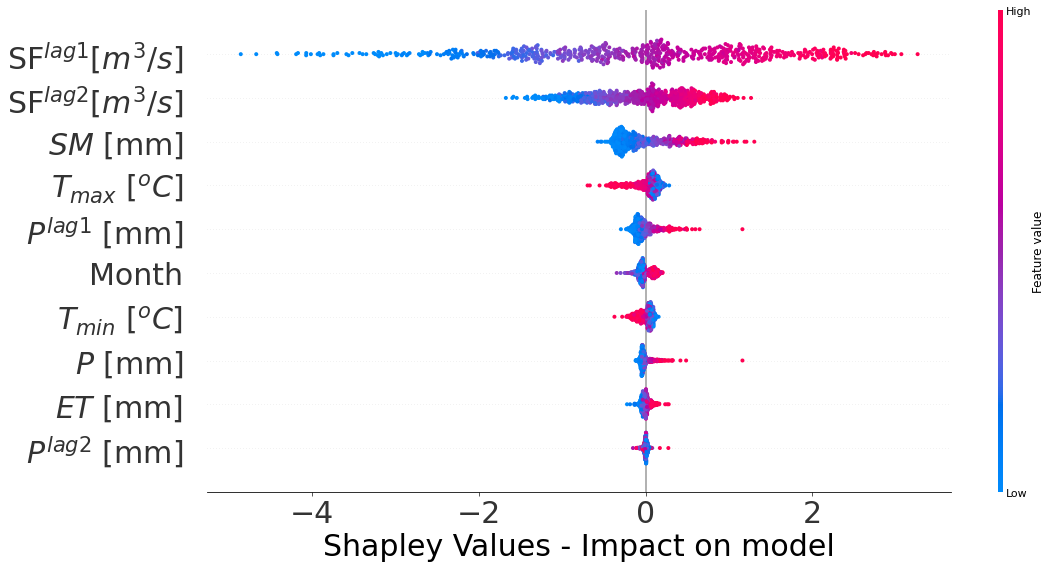

In [ ]:
explainer = shap.TreeExplainer(Model)
shap_values = explainer.shap_values(df_AI2[Features].to_numpy())

shap.summary_plot(shap_values, df_AI2[Features].to_numpy(), Features, plot_size=(16,8), show=False)
plt.xlabel('Shapley Values - Impact on model', fontsize=30)
plt.tick_params(labelsize=30)
plt.tight_layout(pad=1.08)
plt.savefig(save_Model +str('/Feature Importance ET-SM- SF.pdf'), format='pdf', dpi=300, bbox_inches ='tight')

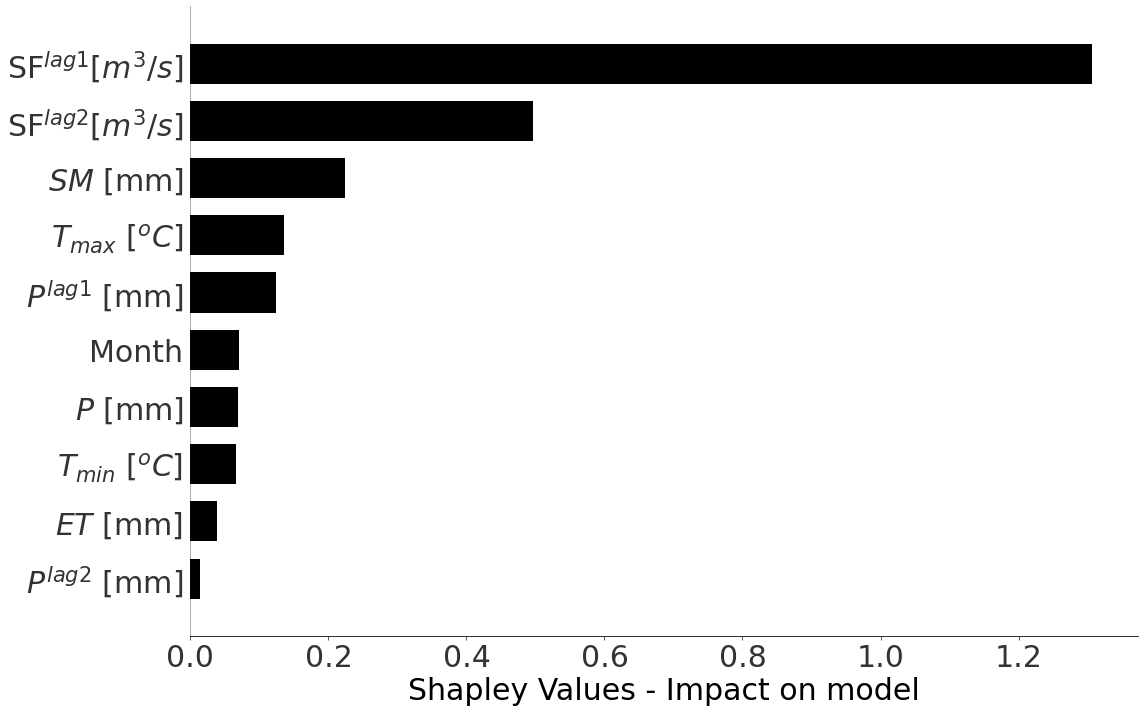

In [ ]:
#################################################################################################
# Update Model SpringFLow Model
#################################################################################################20
#With the whole data from 1946 -2020
Model = Model.fit(X, Y)

explainer = shap.TreeExplainer(Model)
shap_values = explainer.shap_values(df_AI2[Features].to_numpy())

shap.summary_plot(shap_values, df_AI2[Features].to_numpy(), Features, plot_size=(16,10), show=False, 
                  plot_type = "bar", color = "black")
plt.xlabel('Shapley Values - Impact on model', fontsize=30)
plt.tick_params(labelsize=30)
plt.tight_layout(pad=1.08)
plt.savefig(save_Model + str('/Feature Importances SMET- SF_Comal - Hist.jpg'), format='jpeg', dpi=300, bbox_inches ='tight')


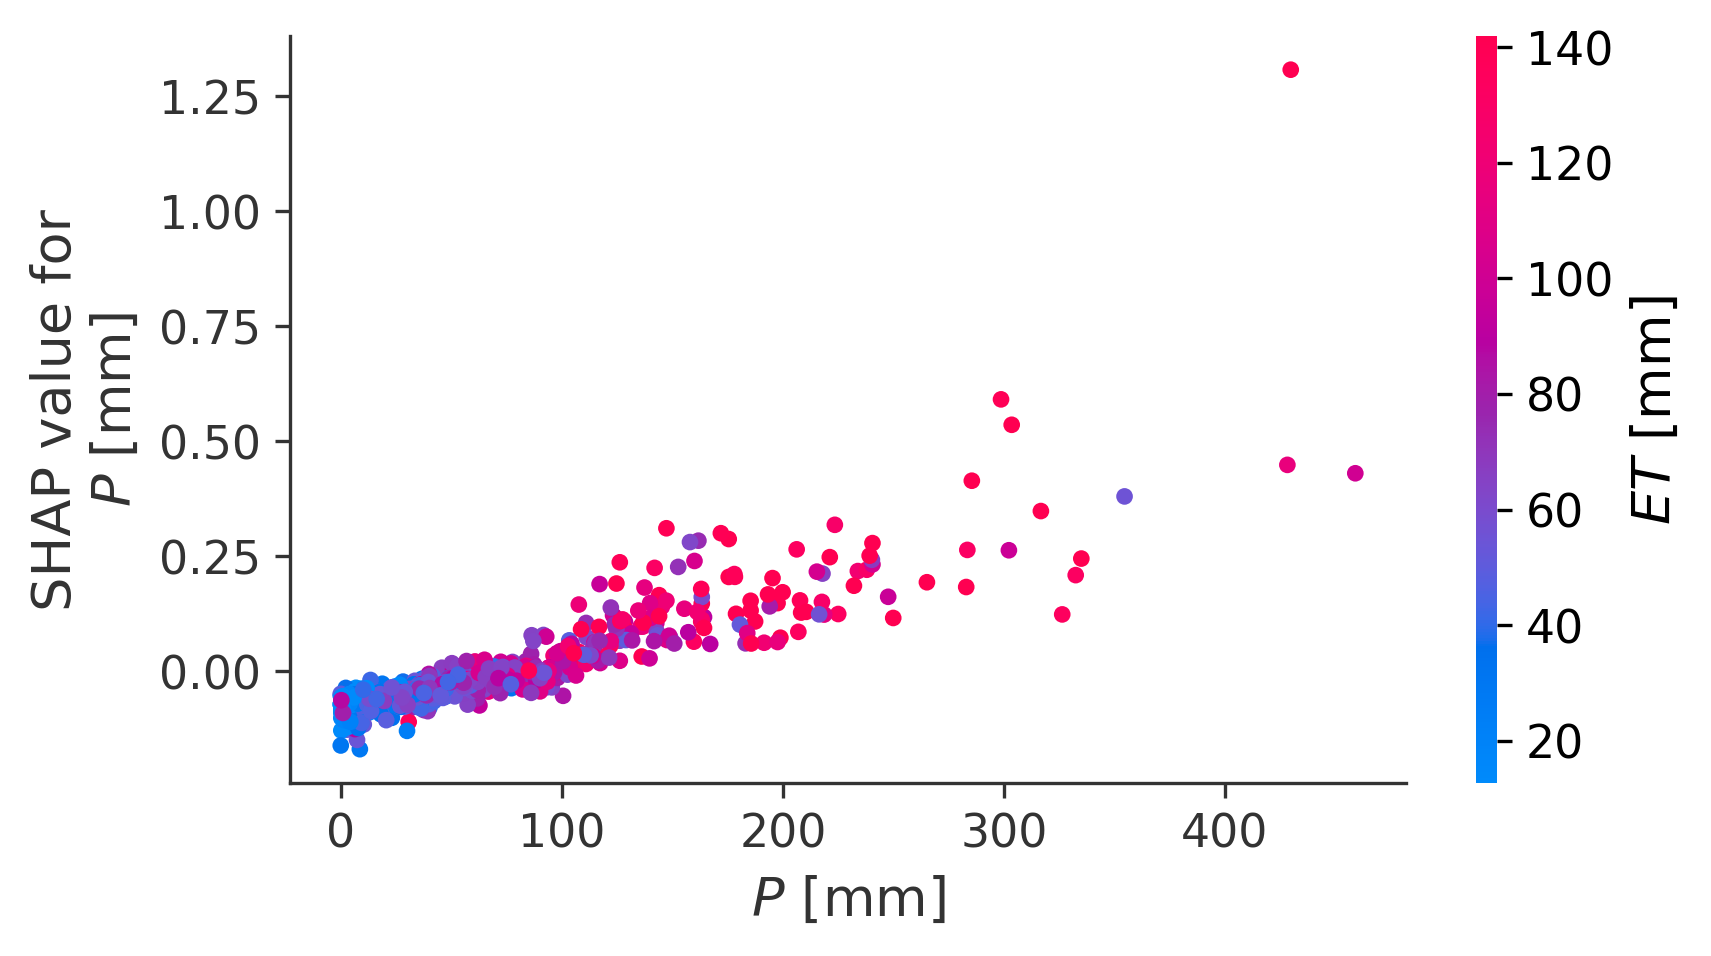

In [ ]:
fig = plt.figure(figsize=(6,3.3),dpi=300)
ax1 = fig.add_subplot(1,1,1)

   
shap.dependence_plot('$P$ [mm]',shap_values, df_AI2[Features].to_numpy(),Features, ax=ax1, show=False,
                     interaction_index='$ET$ [mm]')
plt.savefig(save_Model +str('/Feature Interaction_comal_springs  - Pr-ET2 -Comal Hist.jpg'), format='jpeg', dpi=300, bbox_inches ='tight')


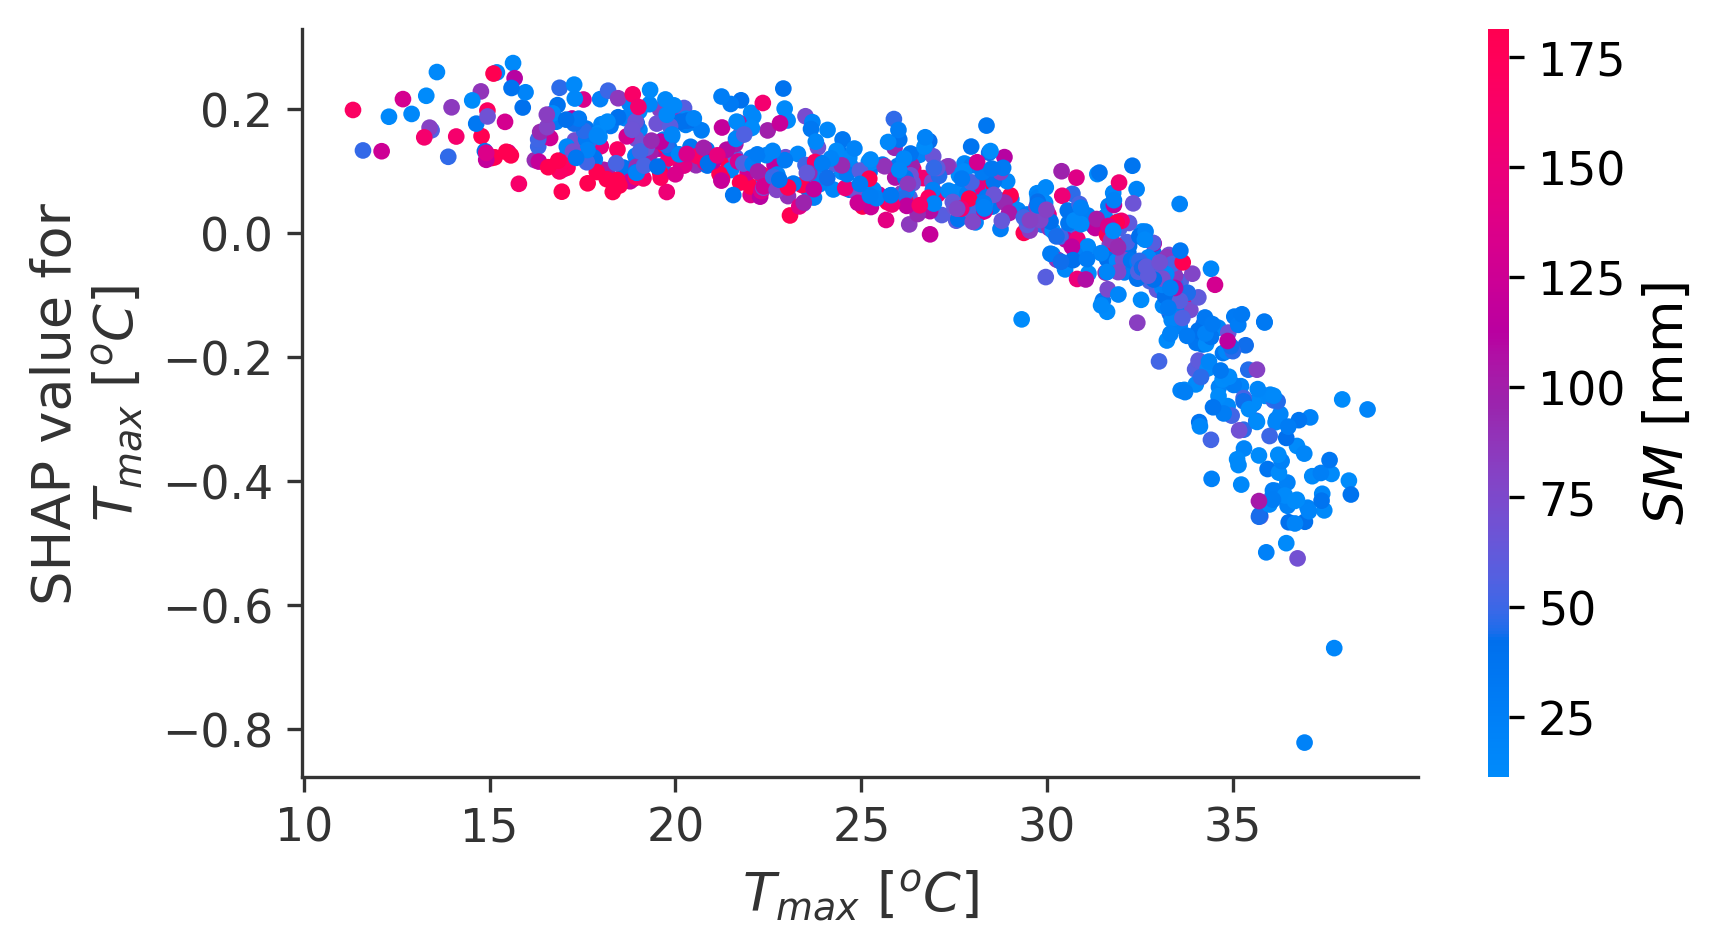

In [ ]:

fig = plt.figure(figsize=(6,3.3),dpi=300)
ax1 = fig.add_subplot(1,1,1)

   
shap.dependence_plot('$T_{max}$ [$^oC$]', shap_values, df_AI2[Features].to_numpy(),Features, ax=ax1, show=False,
                     interaction_index='$SM$ [mm]')
plt.savefig(save_Model +str('/Feature Interaction_comal_springs - Tmax2 - Hist.jpg'), format='jpeg', dpi=300, bbox_inches ='tight')
